# Mixture of experts

## Before deep learning

[Mixture of Experts](https://en.wikipedia.org/wiki/Mixture_of_experts) is an old technique dating back to 1991. Back in the old days before deep learning, it was mainly studied as a generalized version of *mixture models* in statistics. For example, if you have a statistical distribution with two humps, you can model it as the weighted sum of two gaussians. That would be a mixture of gaussians.

[![](https://upload.wikimedia.org/wikipedia/commons/7/71/Gaussian-mixture-example.svg)](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model)

A mixture of experts is then a simple generalization, and training a mixture of experts, back in the old days, was mostly thought of as statistical inference. The main problem was simply modelling complex data with a larger family of statistical distribution. Their main worry was that the experts would overfit.

They had little data (enough to fit onto a floppy disk), and each expert was usually just a gaussian distibution or a logistic classifier (any more complex and they wouldn't know how to calculate the integrals and derivatives). Consequently, what they ended up trying to solve was to fit a few thousand datapoints using tens of very simple experts.

It is a general fact of classical machine learning that they were very worried about overfitting, and it is reasonable back then to worry, since they had such small datasets (MNIST was in 1994). This, combined with their inability to hand-design learning algorithms for complex machine learning architectures and the slowness of pure gradient descent, meant that machine learning algorithms back then were simple ones fitted onto small datasets.

The overall effect is:
* getting training data: expensive (you have to do it yourself)
* designing the algorithm: expensive (cheaper if you have graduate students)
* training compute: moderate to high (though a few pioneers have bravely pushed to the "very expensive" regime, and failed[^norvig2021])
* inference compute: very cheap (since that you wouldn't be able to train anything large)

[^norvig2021]: [Peter Norvig – Singularity Is in the Eye of the Beholder | gradient-dissent – Weights & Biases](https://wandb.ai/wandb_fc/gradient-dissent/reports/Peter-Norvig-Google-s-Director-of-Research-Singularity-is-in-the-eye-of-the-beholder--Vmlldzo2MTYwNjk?galleryTag=gradient-dissent)

>  I certainly remember Geoff Hinton came to Berkeley when I was a grad student in 1981, I think, when he talked about these neural nets. And we fellow grad students thought that was so cool. So we said, "Let's go back into the lab and implement it.
>
> And of course, there was absolutely nothing you could download, so we had to build it all from scratch. And we got it to do XOR, and then we got it to do something a little bit more complicated. And it was exciting. And then we gave it the first real problem, and it ran overnight, and it didn't converge, and we let it run one more day, and it still didn't converge. And then we gave up, and we went back to our sort of knowledge-based systems approach. But if we had the computing power of today, it probably would have converged after five seconds.

This should be compared to the very different situation with deep learning:

* getting training data: cheap (just download it online)
* designing the algorithm: cheap (make a standard network, add a few decorations, then use backprop with Adam optimizer)
* training compute: as expensive as you want
* inference compute: as expensive as you want

## After deep learning

While classical statistics and machine learning was mainly constrained by how many partial derivatives and integrals the statistician can calculate confidently on paper[^1], deep learning is mainly constrained by memory and compute budget.

[^1]: If you want a taste of the old days, look at the formulas inside "Hierarchical mixtures of experts and the EM algorithm" (Jordan, Michael I., and Robert A. Jacobs, 1994)

So when the deep learning era came circa 2012, people immediately started  looking into how to perform **conditional computing**: save computing cost by only calling a small portion of the model. The idea is that you would have different portions of the model be specialized for different forms of input, and for each input, the model would first cheaply find out which expert should handle it, then call upon only the few specialized experts to handle this particular input.

Deep learning came with AlexNet (2012), and the first paper on applying MoE to deep learning was "Learning Factored Representations in a Deep Mixture of Experts" (2013). Things really started heating up though with sparsely-gated MoE (2017).

## Why MoE for deep learning?

Generally, one uses a MoE on the frontier, because:

* You really need to push the metric up by a few points.
* You can't train a dense model larger than the frontier model, because it simply fails to converge, or the hyperparameter settings for the small models don't work for the larger one (and you can't just run a grid search to find it because it costs a million dollars to do a single run).
* You can train around 10 copies of the frontier model, because while you don't have the money to do grid search beyond the current frontier, you have the money to train 10 at the frontier.
* You can't infer a dense model larger than the frontier one, because one dense model $N$ times as wide would cost you $N^2$ amount of storage *and* compute, while if you just train $N$ experts, each with roughly the same architecture as the dense model, it would cost you about $N$ amount of storage *and* about $2$ amount of compute (if only 2 experts are called per query).
* Indeed, if there are too many parameters, then it can't even be fit onto a good GPU and must be split across GPUs, and then the GPU-GPU communication becomes a serious problem (the "von Neumann bottleneck").

[![](https://cs61.seas.harvard.edu/site/img/storage-hierarchy.png)](https://cs61.seas.harvard.edu/site/2018/Storage2/)

All of which are satified by Microsoft, Google, etc. This explains the "rumored" (all but certain at this point) that GPT-4 is a MoE made by multiple GPT-3-like models.

A quick scan of the recent literature shows this:

* Outrageously Large Neural Networks (Google, 2017): *We present model architectures in which a MoE with up to 137 billion parameters is applied convolutionally between stacked LSTM layers.*
* Switch transformers (Google, 2020): *Combining expert, model and data parallelism, we design two large Switch Transformer models, one with 395 billion and 1.6 trillion parameters, respectively.*
* Scaling Vision with Sparse Mixture of Experts (Google again, 2021): *we demonstrate the potential of V-MoE to scale vision models, and train a 15B parameter model that attains 90.35% on ImageNet.*

The "Outrageously Large Neural Networks" paper is not the first paper on MoE in the deep learning era, but it is the most important one. Also notice that it was applied to between "stacked LSTM layers", because it was published before Transformers, back when neural language models meant stacks of LSTM. Nowadays, of course, MoE usually means MoE layers within Transformers, because only with Transformers do people regularly train models beyond 10 billion parameters.

## Classical MoE

The classical version of MoE is fairly simple: You start with a few machine learning models and then you ensemble them together.

In this example, we train a binary classifier for points in $\mathbb R^2$. The distribution is constructed so that points are more likely to be class 1 in the upper-right quadrant, and more likely to be class 0 in the other 3 quadrants.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate the dataset
def generate_dataset(num_samples, sharpness=5):
    X = np.random.randn(num_samples, 2)
    p = np.minimum(np.exp(sharpness * np.minimum(X[:, 0], X[:, 1])), 1)
    y = np.random.binomial(1, p, size=num_samples)
    return X, y

In [ ]:
# Generate the dataset
num_samples = 1000
X, y = generate_dataset(num_samples)

# Split the dataset manually
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Plot the dataset
def plot_dataset(X, y, ax):
    ax.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', marker='o', c='blue')
    ax.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', marker='x', c='red')
    ax.set_title('Dataset Scatter Plot')
    return ax

fig, ax = plt.subplots(figsize=(8, 6))
plot_dataset(X_test, y_test, ax)
plt.show()

In our MoE model, each expert is just a linear logistic classifier:

$$Pr_\theta(y = 0 | x) = \frac{1}{1 + e^{\theta_0^T x + \theta_1}}$$

The weights are found by linear-softmax:

$$Pr(y=0 | x ) = \sum_i w(x)_i Pr_{\theta^{(i)}}(y = 0 | x)$$

with

$$w(x) = \mathrm{softmax}(Ax)$$

for a learned matrix $A$.

**What should the MoE learn? How many experts should it use?**

########################################################################

TODO: your answer here

########################################################################

It should learn to use two experts, one classifying points based on their $x_1$ value only, and one based on $x_2$ only.

The weighting matrix should be such that if the point is below the diagonal line, then it uses the first expert; if the point is above the diagonal line, then it uses the second expert.

For example, these would work:

$$Pr_{\theta^{(1)}}(y = 0 | x) = \frac{1}{1 + e^{10 x_1}}$$

$$Pr_{\theta^{(2)}}(y = 0 | x) = \frac{1}{1 + e^{10 x_2}}$$

$$
A = \begin{bmatrix}
+10 & 0 \\
0 & +10
\end{bmatrix}
$$

########################################################################

Suppose now we have a different binary dataset, with $y = 0$ inside the square $[-1, +1]^2$, and $y=1$ outside the square.

**Can we still use a MoE with linear logistic experts? If so, what is the weight matrix like, and how many experts do we need?**

########################################################################

TODO: your answer here

########################################################################

Yes. We need 4 experts, and the weight matrix can be like

$$
A = \begin{bmatrix}
+10 & 0 \\
-10 & 0 \\
0 & +10 \\
0 & -10
\end{bmatrix}
$$

In general, if the datapoints labelled 0 and 1 are separated by a union of polygons, then we can use a mixture of linear logistic experts.

########################################################################

### Training a tiny MoE

Let's train a small MoE with just 6 experts.

In fact, we can compare the model's performance with the Bayes-optimal predictor. We know the Bayes-optimal predictor, since it is just the dataset distribution, which we designed ourselves!

In [3]:
class MoE(nn.Module):
    def __init__(self, input_dim, num_experts, output_dim):
        super(MoE, self).__init__()
        self.experts = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(num_experts)])
        self.weighting = nn.Linear(input_dim, num_experts)

    def forward(self, x, mask=None):
        if mask is not None:
            weights = torch.softmax(self.weighting(x) + mask, dim=1)
        else:
            weights = torch.softmax(self.weighting(x), dim=1)
        expert_outputs = [expert(x) for expert in self.experts]
        output = torch.stack(expert_outputs, dim=2)  # Stack expert outputs along dimension 2
        weighted_output = torch.sum(output * weights.unsqueeze(1), dim=2)
        return weighted_output

    def sparse_forward(self, x, sparsity):
        norms = self.weighting.weight.norm(dim=1)
        topk_indices = torch.topk(norms, sparsity).indices
        mask = torch.full_like(norms, -1000.0)
        mask[topk_indices] = 0
        return self.forward(x, mask=mask)

    def sparsely_gated_forward(self, x, sparsity):
        weighted_output = None
        ########################################################################
        # TODO: implement sparsely-gated inference
        # Hint: look at how `sparse_forward` is implemented.
        ########################################################################
        wx = self.weighting(x)
        bottomk_indices = torch.topk(wx, len(self.experts) - sparsity, dim=1, largest=False).indices

        mask = torch.zeros_like(wx)
        mask.scatter_(1, bottomk_indices, -1e6)
        wx = wx + mask

        weights = torch.softmax(wx, dim=1)
        expert_outputs = [expert(x) for expert in self.experts]
        output = torch.stack(expert_outputs, dim=2)  # Stack expert outputs along dimension 2
        weighted_output = torch.sum(output * weights.unsqueeze(1), dim=2)
        ########################################################################
        return weighted_output

class BayesOptimal(nn.Module):
    def __init__(self, sharpness=5):
        super(BayesOptimal, self).__init__()
        self.sharpness = sharpness

    def forward(self, X):
        exp_term = torch.exp(self.sharpness * torch.minimum(X[:, 0], X[:, 1]))
        ps = torch.minimum(exp_term, torch.ones_like(exp_term))
        y = torch.ones_like(X)
        y[:,0] -= ps
        y[:,1] = ps
        y += 1e-6
        return y.log()

In [10]:
# Hyperparameters
num_samples = 10000
input_dim = 2
num_experts = 6
output_dim = 2
learning_rate = 0.05
num_epochs = 2000

# Generate the dataset
X, y = generate_dataset(num_samples)

# Split the dataset into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Create and initialize the MoE model
model = MoE(input_dim, num_experts, output_dim)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

ref_model = BayesOptimal()
ref_model.eval()
with torch.no_grad():
    outputs = ref_model.forward(X_train)
    loss = criterion(outputs, y_train)
    print(f'Bayes optimal loss: {loss.item():.4f}')

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model.forward(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    ref_outputs = ref_model.forward(X_test)
    _, predicted = torch.max(test_outputs, 1)
    _, ref_predicted = torch.max(ref_outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    ref_accuracy = (ref_predicted == y_test).sum().item() / y_test.size(0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Bayes optimal Accuracy: {ref_accuracy:.4f}')

Bayes optimal loss: 0.1581
Epoch [500/2000], Loss: 0.1599
Epoch [1000/2000], Loss: 0.1584
Epoch [1500/2000], Loss: 0.1580
Epoch [2000/2000], Loss: 0.1578
Test Accuracy: 0.9425
Bayes optimal Accuracy: 0.9410


## Sparsifying MoE

Given a MoE, there are two ways to use it. One can use it as-is, but then every expert must be consulted on every query, defeating the main purpose of MoE in the age of large models: conditional computing.

We will try out two ways to sparsify a trained MoE. In the first MoE paper (1991), they inspected the weights (the matrix $A$ in our notation), and found that some experts would never be called on any input. Then they just removed those experts. This can be understood as sparsification "at compile time".

Here, we implement sparsification "at compile time" by ranking the rows of $A$ according to their L2-norm, find the top-k rows of them, then mask out all the other experts.

This implementation is given to you as the method `sparse_forward` in `class MoE`.

In the **sparsely-gated MoE**, the sparsification is done "at runtime". That is:

$$w(x) = \mathrm{softmax}(\mathrm{top}_k(Ax))$$

where $\mathrm{top}_k(v)$ preserves the top-k entries of $v$, but set all other entries to $-\infty$.

The implementation is not given to you. You should **go back and implement** the method `sparsely_gated_forward` in `class MoE`.

After you have implemented `sparsely_gated_forward`, answer this question:

**Assume our MoE is well-trained. What sparsity should it use for "at compile time"? What sparsity should it use for "at run time"?**

########################################################################

TODO: your answer here

########################################################################


Sparsification at compile time requires $k=2$, since it needs two experts on board to process all datapoints.

Sparsification at run time requires just $k=1$, since it basically still has all 6 experts on board, but only needs to call on one per datapoint.

########################################################################

Let's see how well your prediction holds. Run the next two cell blocks and look at the resulting images. If they don't look like what you expected, then double check your implementation of `sparsely_gated_forward`.

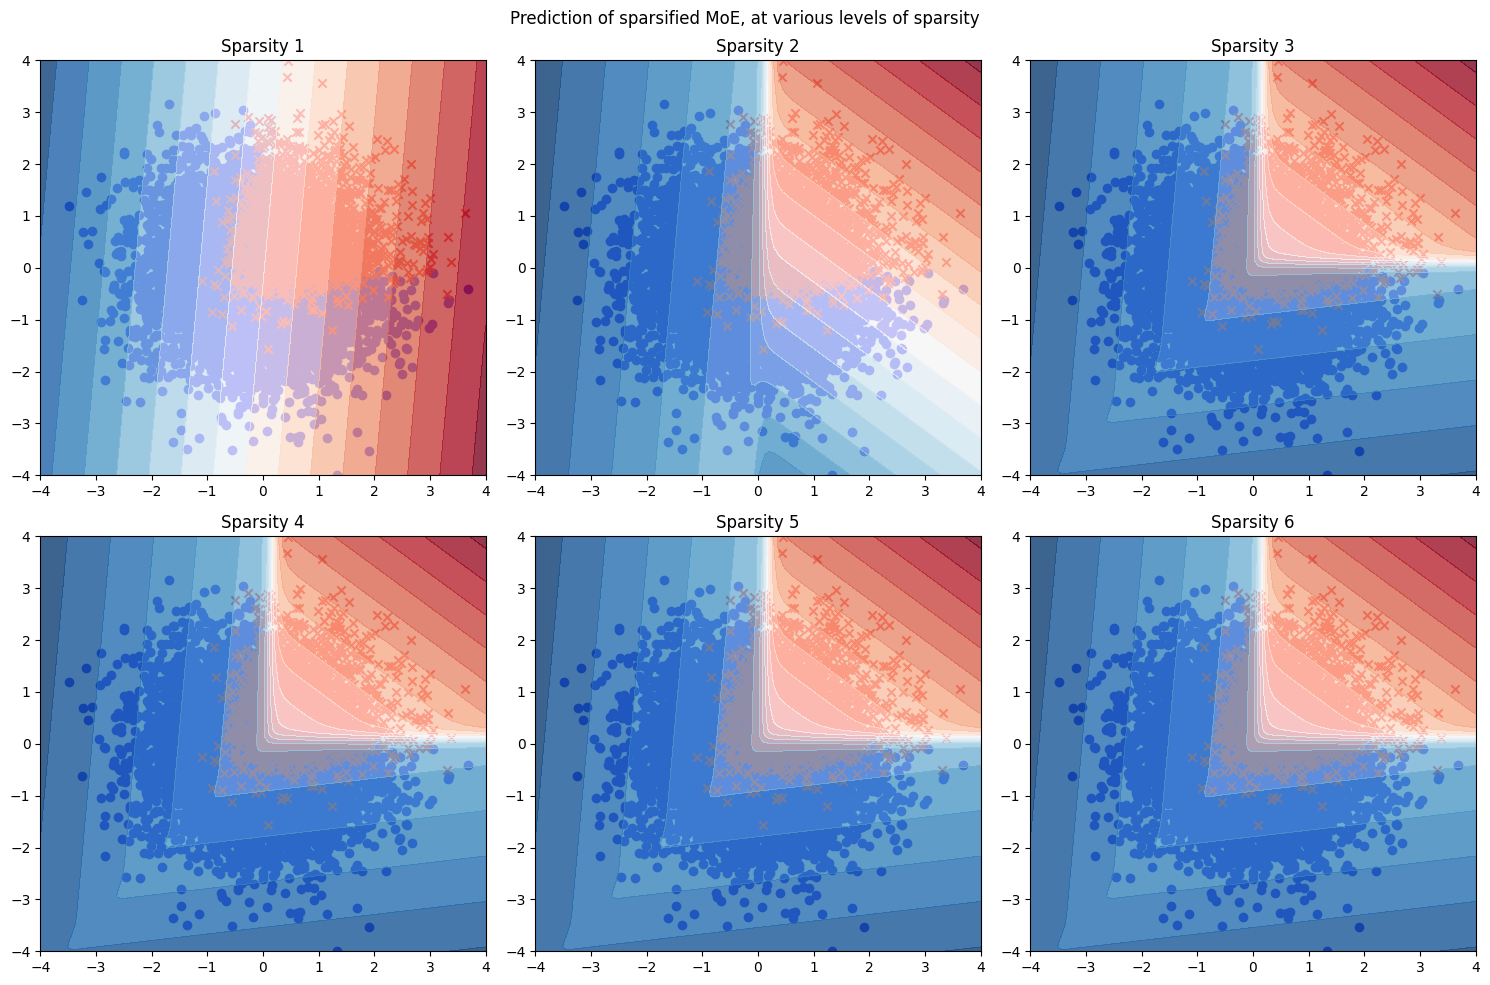

In [11]:
sparsity_values = range(1, 7)

# Create a 2x3 grid of subfigures
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop through the sparsity values and create individual heatmaps in each subfigure
for i, sparsity in enumerate(sparsity_values):
    # Define a mesh grid for visualization
    x_min, x_max = -4, 4
    y_min, y_max = -4, 4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Flatten the mesh grid and make predictions using the MoE model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.FloatTensor(grid_points)
    with torch.no_grad():
        Z = model.sparse_forward(grid_points, sparsity).numpy()
    Z = Z[:, 1].reshape(xx.shape)  # We are interested in the probability of class 1

    # Plot the heatmap in the current subfigure
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Plot the dataset points (assuming you have a function plot_dataset for this)
    plot_dataset(X_test, y_test, ax)

    # Plot the heatmap
    heatmap = ax.contourf(xx, yy, Z, levels=20, cmap=plt.cm.RdBu_r, alpha=0.8)

    # Set the title and axis limits for the current subfigure
    ax.set_title(f'Sparsity {sparsity}')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig.suptitle("Prediction of sparsified MoE, at various levels of sparsity")
plt.tight_layout()
plt.show()

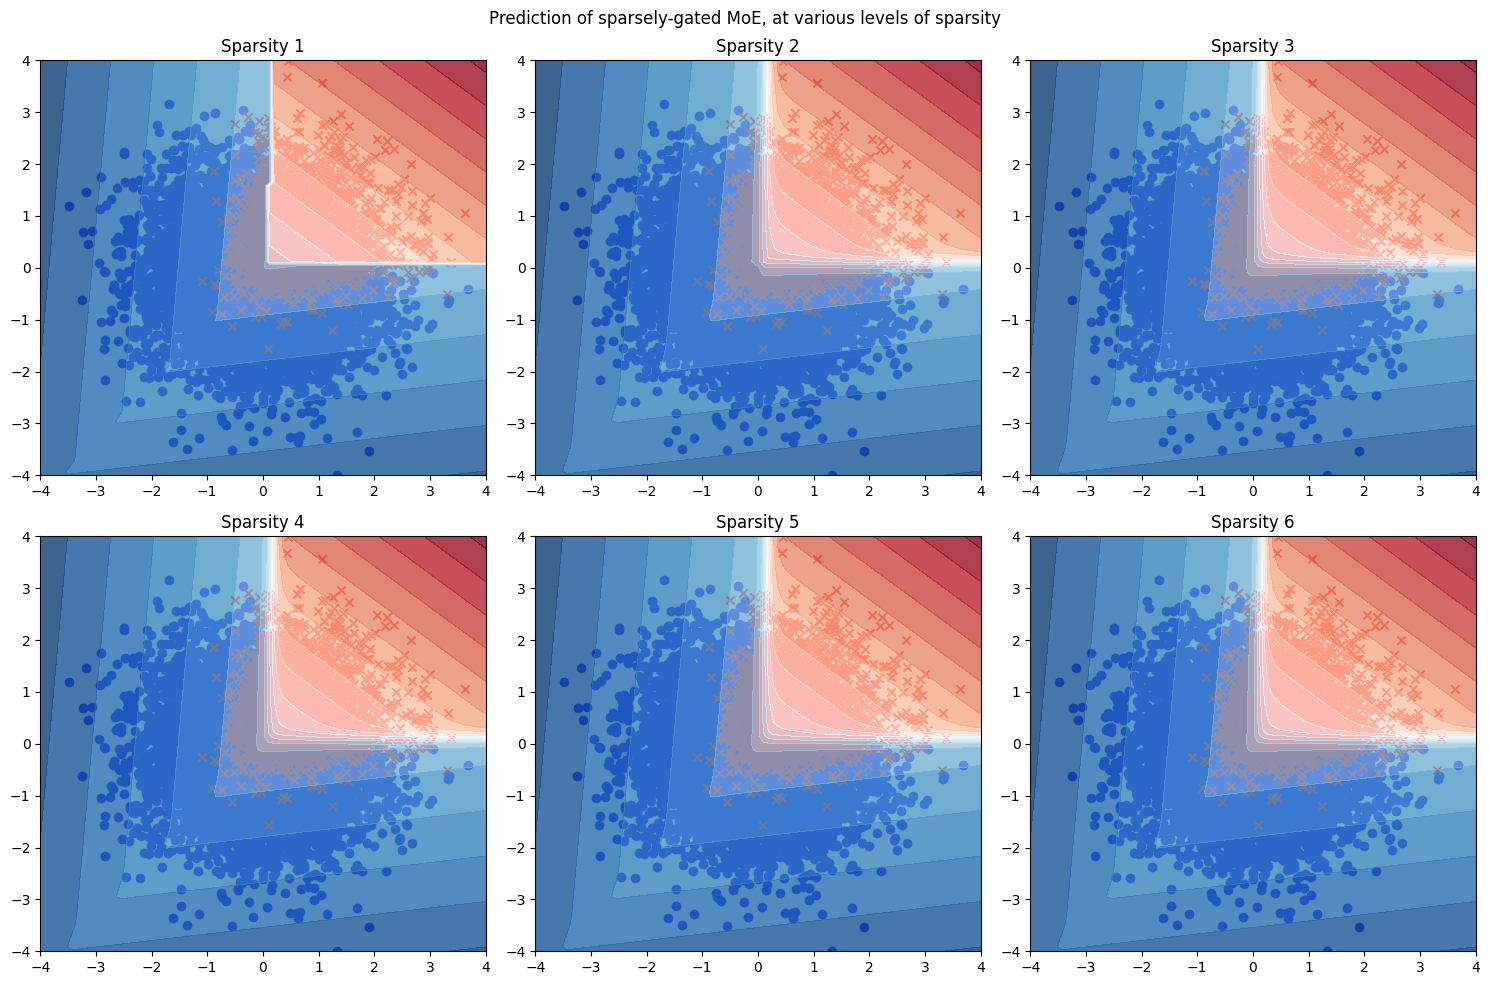

In [12]:
sparsity_values = range(1, 7)

# Create a 2x3 grid of subfigures
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop through the sparsity values and create individual heatmaps in each subfigure
for i, sparsity in enumerate(sparsity_values):
    # Define a mesh grid for visualization
    x_min, x_max = -4, 4
    y_min, y_max = -4, 4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Flatten the mesh grid and make predictions using the MoE model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.FloatTensor(grid_points)
    with torch.no_grad():
        Z = model.sparsely_gated_forward(grid_points, sparsity).numpy()
    Z = Z[:, 1].reshape(xx.shape)  # We are interested in the probability of class 1

    # Plot the heatmap in the current subfigure
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Plot the dataset points (assuming you have a function plot_dataset for this)
    plot_dataset(X_test, y_test, ax)

    # Plot the heatmap
    heatmap = ax.contourf(xx, yy, Z, levels=20, cmap=plt.cm.RdBu_r, alpha=0.8)

    # Set the title and axis limits for the current subfigure
    ax.set_title(f'Sparsity {sparsity}')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig.suptitle("Prediction of sparsely-gated MoE, at various levels of sparsity")
plt.tight_layout()
plt.show()


## Training a sparsely-gated MoE directly

I also tried training a sparsely-gated MoE directly using backprop, but the result is much less stable and achieved significantly lower accuracy. My guess is that the sparsely-gated MoE has "sharp edges" in loss landscape.

Indeed, the review paper [ST-MoE: Designing stable and transferable sparse expert models (2022)
](https://arxiv.org/pdf/2202.08906.pdf) says

> Sparse models often suffer from training instabilities worse than those observed in standard densely-activated Transformers.

This is unsettled, a current field of ML engineering research.

## Load balancing

Vanilla MoE tend to have issues of load balancing: some experts are consulted often, while other experts rarely or not at all.

For example, in the very first paper on MoE \footnote{Jacobs, Robert A., et al. "Adaptive mixtures of local experts." Neural computation 3.1 (1991): 79-87.}, they trained 6 experts to recognize phonemes from 6 Japanese speakers. They found that the trained MoE would give close to zero weighting on all but 3 experts:

> Only experts 4, 5, and 6 are active in the final mixture. This solution is typical - in all simulations with mixtures of 4 or 8 experts all but 2 or 3 experts had mixing proportions that were effectively 0 for all cases.

This might not have been a serious problem in the past, when neural networks were seen as merely a form of high-dimensional statistical model learnable by any one of the typical statistical algorithms (maximal likelihood, Bayesian inference, expectation maximization...). Nowadays, MoE are used because you need to throw more compute at the problem, but cannot train a larger dense model. In this case, it would defeat the purpose of MoE if a substantial portion of experts end up neglected.

It is no coincidence, then, that the sparsely-gated MoE layer (2017) paper specifically used two auxiliary loss functions to encourage the experts to have equal "weight" over time. This is simplified to just one auxiliary loss function in the Switch Transformers paper (2020).

Specifically, consider the sparsely-gated MoE with $k=1$ -- where just the top-ranked expert is consulted every time. Let $n$ be the number of experts, and consider a batch of queries $\{x_1, x_2, ..., x_T\}$, then the auxiliary loss of the batch is

$$
L := n \sum_{i=1}^n f_i P_i
$$
where $f_i=\frac{1}{T} \#(\text{queries sent to expert $i$})$ is the fraction of time where expert $i$ is ranked highest, and $P_i=\frac{1}{T} \sum_{j=1}^T w_i\left(x_j\right)$ is the fraction of weight on expert $i$.

In the original paper, they claimed that we can obtain the minimal auxiliary loss $L$ at the limit where every expert has equal weight $1 / n$ on all samples, and every expert is ranked the highest equally often.

**Assuming this is so, what is the minimal loss?**

########################################################################

TODO: your answer here

########################################################################

Plugging in the equations, we find it is $1$.

########################################################################

Unfortunately, the original paper is wrong!

**When there are many experts, and large batch, construct a way to let $L$ approach $1/2$.** It is not difficult to show that $1/2$ is in fact the lower bound, but you are not required to show this.

Hint: Run the next code blocks, with various settings of $T, n$ and look at its outputs. Can you find a pattern? Notice that you should not use $T, n$ larger than $10$ as it would take too much time to run.

########################################################################

TODO: your answer here

########################################################################

Construction: At the limit of many experts, let one expert get $1/2 - \epsilon$ on every question, but never consulted on anything, and let every other $n-1$ expert evenly divide the rest of the questions.

If you run the next code blocks, you would notice that this is precisely what the `dual_annealing` optimizer finds.

In particular, when $T, n = 10$, you would see that when there are 10 experts on 10 queries, the global minimum happens when 1 expert is never consulted, and the other 9 experts try their best to divide the questions evenly (1 query for eight experts and 2 queries for one expert).

The sum of weights is also roughly divided perfectly between the experts.

########################################################################

I tried to show that this thing actually converges to the global minimum by direct minimization, but strangely, direct optimization with SciPy optimize always fails to converge to ~1/2. It even fails to converge to ~1. Indeed, often it just moves around the initial point a bit then immediately gives up and stops. My suspicion is that the loss landscape is too jagged.

If you however use a global optimization method like `dual_annealing`, then the minimimum can be found. I am unsure of the implications for using the auxiliary loss in a real MoE system, but seeing that Google has been training those huge models since 2017, I would guess that it really does work as a load balancing loss.

Too bad that I don't have a thousand TPU-days to test it.

In [7]:
import numpy as np
from scipy.special import softmax
from scipy.optimize import minimize
import scipy

# Define the dimensions of the matrix
T = 10
n = 10


def helper_function(x):
    x_matrix = x.reshape((T, n))

    w = softmax(x_matrix, axis=1)
    max_indices = np.argmax(w, axis=1)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.mean(max_indices == i)
    P = np.mean(w, axis=0)
    return f, P

def objective_function(x):
    f, P = helper_function(x)
    L = n * np.sum(f * P)
    return L

# Initialize x with random values
x_initial = np.array([[10, -1],
                      [0, 1],
                      [0, 1],
                      [0, 1]])
x_initial = np.random.randint(0, 10, size=(T, n))

print(-objective_function(x_initial))
# Minimize the objective function L
result = scipy.optimize.dual_annealing(objective_function,
                                      bounds=[(-10, 10)]*(n*T))

# Extract the optimized x matrix
x_optimized = result.x.reshape((T, n))

# Print the optimized x matrix and the minimized L value
print("Optimized x:")
print(x_optimized)
print("Minimized L value:", -result.fun)
print(softmax(x_optimized, 1))

-1.3538919974263774
Optimized x:
[[-7.18841525 -1.98201209  0.29472938 -1.53703515  9.51957852  1.50085592
  -8.09041903 -5.35152769  9.51959336 -0.8091157 ]
 [-5.74711515 -7.39181575 -7.66116695 -7.60182653  2.73222149 -4.02370492
  -7.53351752  2.73416738 -8.86090862 -5.50198188]
 [-6.42516917 -0.16049944 -0.38707052  9.81225316  9.81225315 -9.39065313
  -4.57770519  0.98140795 -7.2533315  -9.75648678]
 [ 1.18577822 -4.45089353 -8.67888018  1.88886892  9.70813445 -3.1802769
   9.7089377  -3.02071199 -8.61729263 -1.60650282]
 [-7.38553245 -1.78157869 -5.47513676 -5.80725481  5.55478955  5.55517024
  -2.25750112 -9.17646688 -5.92638938 -5.71368018]
 [ 8.61561762 -9.2891571  -2.23301068 -4.79832008  8.61514443 -7.97719384
  -4.9894965  -4.87264478 -8.97319256 -1.64893186]
 [-1.70552641 -1.57558289 -1.90313975 -2.18565096  9.38878397 -9.80678959
  -7.72597356 -0.20919567  0.87339316  9.38917325]
 [-0.06931182  7.94763367 -2.50060714  0.58690285  7.94727088 -2.5946145
  -2.77132752 -5.445

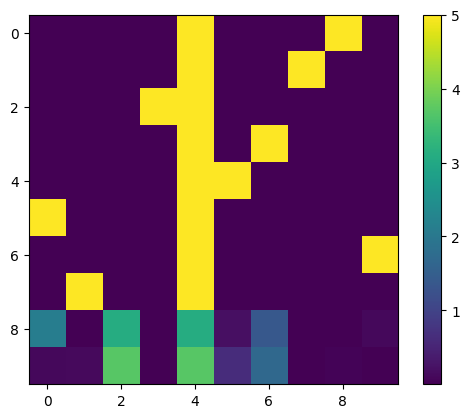

expert 0 is consulted 1 times, with weight 0.72
expert 1 is consulted 1 times, with weight 0.51
expert 2 is consulted 2 times, with weight 0.68
expert 3 is consulted 1 times, with weight 0.50
expert 4 is consulted 0 times, with weight 4.68
expert 5 is consulted 1 times, with weight 0.58
expert 6 is consulted 1 times, with weight 0.81
expert 7 is consulted 1 times, with weight 0.50
expert 8 is consulted 1 times, with weight 0.51
expert 9 is consulted 1 times, with weight 0.51


In [8]:
import matplotlib.pyplot as plt

plt.imshow(softmax(x_optimized, axis=1) * T, cmap='viridis')
plt.colorbar()
plt.show()

f, P = helper_function(x_optimized)
for i in range(len(f)):
    print(f"expert {i} is consulted {T * f[i]:.0f} times, with weight {T * P[i]:.2f}")